## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('bitcoin.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Close')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Open'].values.reshape(-1, 1)

df

,Open
Date,
2020-06-01,9.4545
2020-06-02,10.1907
2020-06-03,9.5270
2020-06-04,9.6672
2020-06-05,9.7940
...,...
2022-05-28,28.6201
2022-05-29,29.0271
2022-05-30,29.4652


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = arima_sc.fit_transform(df_close)
df_scaled

,Open
Date,
2020-06-01,-1.566754
2020-06-02,-1.522736
2020-06-03,-1.562419
2020-06-04,-1.554036
2020-06-05,-1.546455
...,...
2022-05-28,-0.420844
2022-05-29,-0.396509
2022-05-30,-0.370315


# Vẽ đồ thị

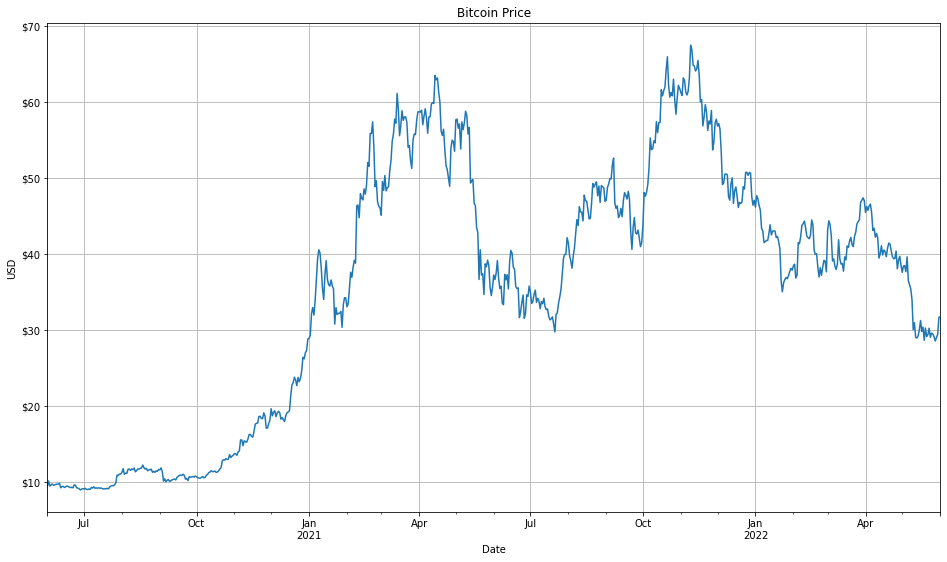

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.7)], df_scaled[(int)(len(df_scaled) * 0.7):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.7):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (511, 1)
test shape:  (220, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Open'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -0.657176
p-value                     0.857532
Number of lags used         0.000000
Number of observations    510.000000
critical value (1%)        -3.443237
critical value (5%)        -2.867224
critical value (10%)       -2.569797
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

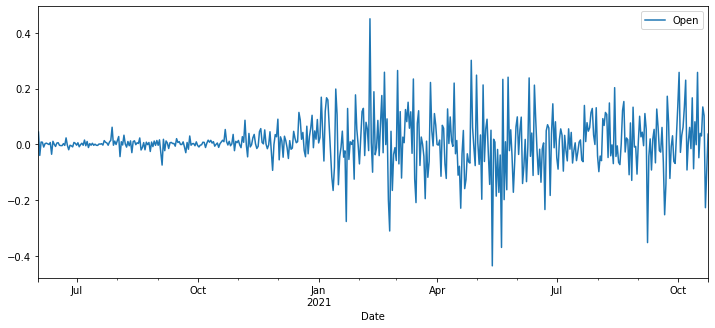

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic        -23.893526
p-value                     0.000000
Number of lags used         0.000000
Number of observations    509.000000
critical value (1%)        -3.443263
critical value (5%)        -2.867235
critical value (10%)       -2.569803
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-999.735, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1003.526, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1003.315, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1003.194, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1003.210, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1001.704, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.376 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  511
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 503.763
Date:                Sun, 26 Jun 2022   AIC                          -1003.526
Time:                        23:39:57   BIC                           -995.057
Sample:                             0   HQIC                         -1000.206
                                - 511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0061      0.004      1.522      0.128      -0.002       0.014
sigma2         0.0081      0.000     27.710      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):               347.18
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):              36.38   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([1.53965519, 1.54573419, 1.55181319, 1.55789219, 1.56397119,
       1.57005019, 1.57612919, 1.58220819, 1.58828718, 1.59436618,
       1.60044518, 1.60652418, 1.61260318, 1.61868218, 1.62476118,
       1.63084018, 1.63691918, 1.64299818, 1.64907717, 1.65515617,
       1.66123517, 1.66731417, 1.67339317, 1.67947217, 1.68555117,
       1.69163017, 1.69770917, 1.70378817, 1.70986716, 1.71594616,
       1.72202516, 1.72810416, 1.73418316, 1.74026216, 1.74634116,
       1.75242016, 1.75849916, 1.76457816, 1.77065715, 1.77673615,
       1.78281515, 1.78889415, 1.79497315, 1.80105215, 1.80713115,
       1.81321015, 1.81928915, 1.82536815, 1.83144714, 1.83752614,
       1.84360514, 1.84968414, 1.85576314, 1.86184214, 1.86792114,
       1.87400014, 1.88007914, 1.88615814, 1.89223713, 1.89831613,
       1.90439513, 1.91047413, 1.91655313, 1.92263213, 1.92871113,
       1.93479013, 1.94086913, 1.94694813, 1.95302712, 1.95910612,
       1.96518512, 1.97126412, 1.97734312, 1.98342212, 1.98950

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

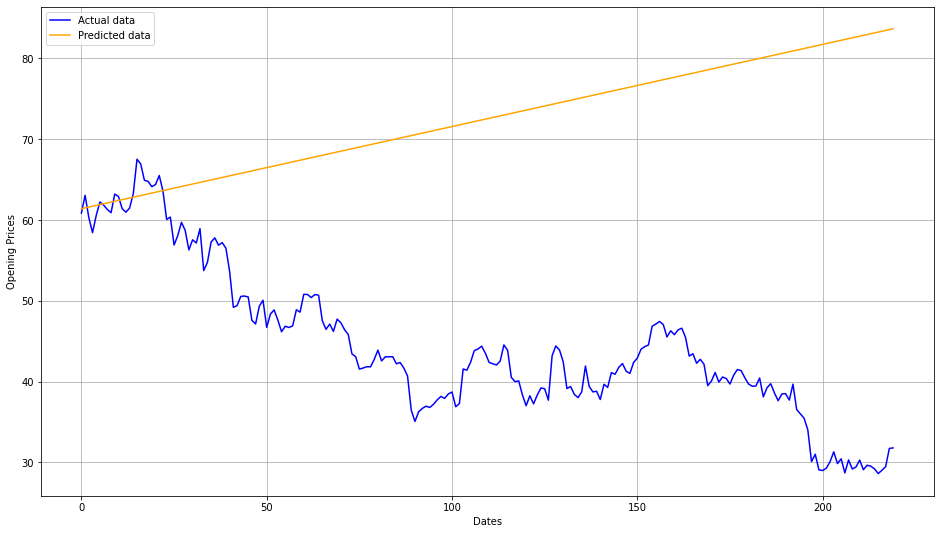

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 28.28
MAPE: 73.20%
MSE: 1020.70
RMSE: 31.95
R2: -10.79


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2021-10-25,60.8643,61.409873,-0.545573
2021-10-26,63.0675,61.511545,1.555955
2021-10-27,60.3125,61.613218,-1.300718
2021-10-28,58.4372,61.714890,-3.277690
2021-10-29,60.5799,61.816563,-1.236663
...,...,...,...
2022-05-28,28.6201,83.269481,-54.649381
2022-05-29,29.0271,83.371153,-54.344053
2022-05-30,29.4652,83.472826,-54.007626


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2021-10-25,60.8643,61.409873,-0.545573
2021-10-26,63.0675,61.511545,1.555955
2021-10-27,60.3125,61.613218,-1.300718
2021-10-28,58.4372,61.714890,-3.277690
2021-10-29,60.5799,61.816563,-1.236663
...,...,...,...
2022-05-28,28.6201,83.269481,-54.649381
2022-05-29,29.0271,83.371153,-54.344053
2022-05-30,29.4652,83.472826,-54.007626


# Vẽ đồ thị thể hiện sai số

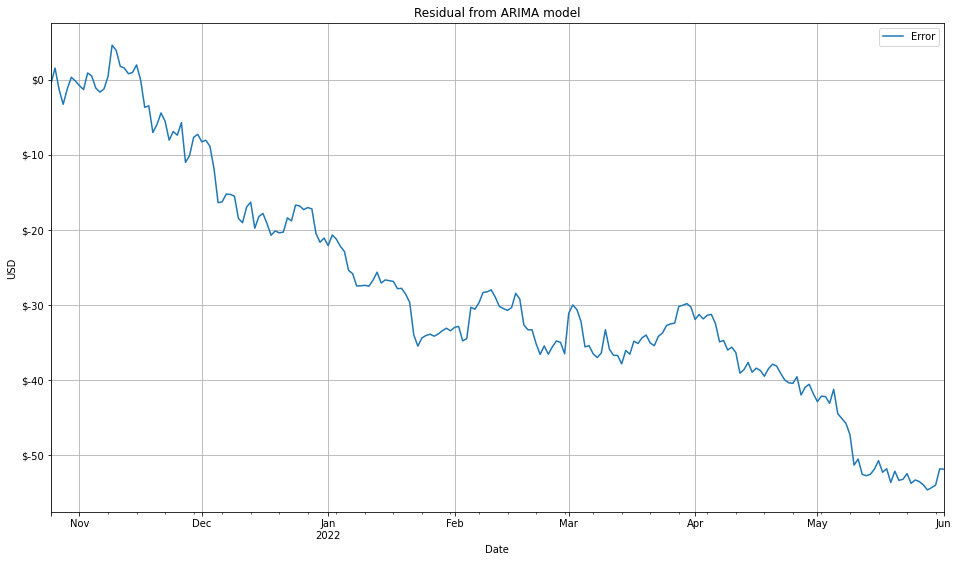

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[-5.45572596e-01],
       [ 1.55595481e+00],
       [-1.30071779e+00],
       [-3.27769038e+00],
       [-1.23666298e+00],
       [ 3.26764425e-01],
       [-1.77708171e-01],
       [-8.11480767e-01],
       [-1.31105336e+00],
       [ 8.98574041e-01],
       [ 4.88801446e-01],
       [-1.11677115e+00],
       [-1.65674375e+00],
       [-1.24781634e+00],
       [ 4.43111062e-01],
       [ 4.59373847e+00],
       [ 3.90596587e+00],
       [ 1.78449327e+00],
       [ 1.54262068e+00],
       [ 7.91648083e-01],
       [ 9.53875487e-01],
       [ 1.96990289e+00],
       [-4.15697048e-02],
       [-3.67414230e+00],
       [-3.48181490e+00],
       [-7.04338749e+00],
       [-5.97256009e+00],
       [-4.43103268e+00],
       [-5.53700528e+00],
       [-8.05357788e+00],
       [-6.90065047e+00],
       [-7.39462307e+00],
       [-5.72609566e+00],
       [-1.10178683e+01],
       [-1.01087409e+01],
       [-7.68031345e+00],
       [-7.27488605e+00],
       [-8.28005864e+00],
       [-8.0

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (217, 3, 1)
y_train (217, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin_7_3.h5")

Epoch 1/300
7/7 [==============================] - 3s 6ms/step - loss: 872.6693
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 529.5807
Epoch 3/300
7/7 [==============================] - 0s 5ms/step - loss: 116.6971
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 75.1313
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 21.5986
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 24.7156
Epoch 7/300
7/7 [==============================] - 0s 5ms/step - loss: 12.2680
Epoch 8/300
7/7 [==============================] - 0s 5ms/step - loss: 10.3179
Epoch 9/300
7/7 [==============================] - 0s 7ms/step - loss: 6.4836
Epoch 10/300
7/7 [==============================] - 0s 5ms/step - loss: 5.6528
Epoch 11/300
7/7 [==============================] - 0s 5ms/step - loss: 5.1463
Epoch 12/300
7/7 [==============================] - 0s 5ms/step - loss: 4.8789
Epoch 13/300
7/7 [==============================] 

In [22]:
model = load_model("bitcoin_7_3.h5")
error_pred = model.predict(x_train)
error_pred

7/7 [==============================] - 0s 3ms/step


array([[ -4.274024  ],
       [ -2.2081852 ],
       [  0.17135182],
       [  0.1767771 ],
       [ -1.1445489 ],
       [ -1.0574907 ],
       [ -1.1235924 ],
       [  2.6390586 ],
       [ -1.3044279 ],
       [ -2.0716076 ],
       [ -1.102966  ],
       [  0.23245347],
       [  2.2933598 ],
       [  3.4633536 ],
       [  1.5483112 ],
       [  1.1170428 ],
       [  0.92616665],
       [ -0.27967897],
       [  0.61855584],
       [  0.8264741 ],
       [ -2.3725593 ],
       [ -3.194184  ],
       [ -5.4493475 ],
       [ -6.0158763 ],
       [ -5.94457   ],
       [ -5.89192   ],
       [ -7.2180214 ],
       [ -7.8114696 ],
       [ -7.9403276 ],
       [ -8.587385  ],
       [ -8.186546  ],
       [-11.27708   ],
       [ -9.841344  ],
       [ -8.375892  ],
       [ -8.027507  ],
       [ -9.412271  ],
       [ -9.665406  ],
       [-10.177802  ],
       [-13.499923  ],
       [-16.073164  ],
       [-15.511736  ],
       [-15.67623   ],
       [-16.165524  ],
       [-16

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2021-10-25,60.8643,61.409873,-0.545573,-4.274024
2021-10-26,63.0675,61.511545,1.555955,-2.208185
2021-10-27,60.3125,61.613218,-1.300718,0.171352
2021-10-28,58.4372,61.714890,-3.277690,0.176777
2021-10-29,60.5799,61.816563,-1.236663,-1.144549
...,...,...,...,...
2022-05-25,29.6487,82.964463,-53.315763,-53.400272
2022-05-26,29.5379,83.066136,-53.528236,-53.989395
2022-05-27,29.1940,83.167808,-53.973808,-53.818237


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2021-10-25,60.8643,61.409873,-0.545573,-4.274024,57.135849
2021-10-26,63.0675,61.511545,1.555955,-2.208185,59.303360
2021-10-27,60.3125,61.613218,-1.300718,0.171352,61.784570
2021-10-28,58.4372,61.714890,-3.277690,0.176777,61.891667
2021-10-29,60.5799,61.816563,-1.236663,-1.144549,60.672014
...,...,...,...,...,...
2022-05-25,29.6487,82.964463,-53.315763,-53.400272,29.564191
2022-05-26,29.5379,83.066136,-53.528236,-53.989395,29.076740
2022-05-27,29.1940,83.167808,-53.973808,-53.818237,29.349571


# Vẽ đồ thị

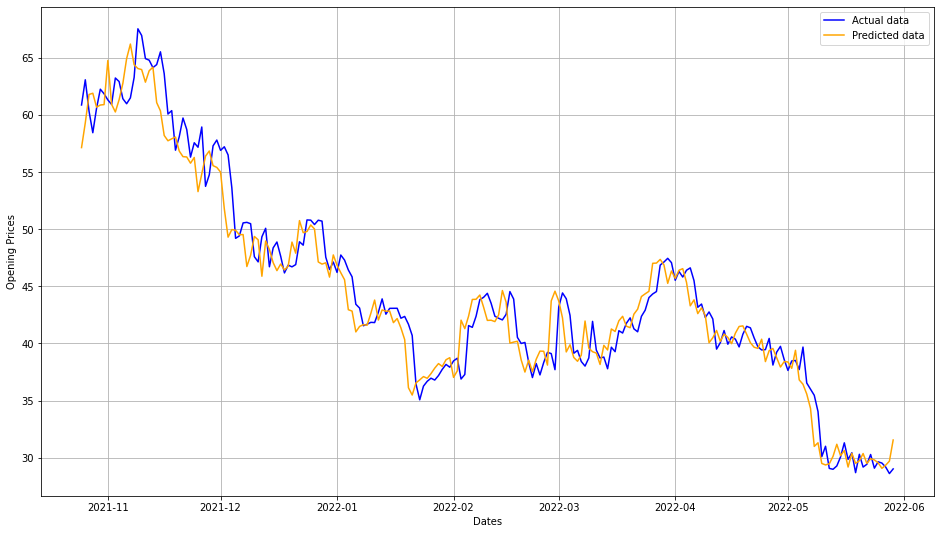

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1.61
MAPE: 3.56%
MSE: 4.59
RMSE: 2.14
R2: 0.95


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -53.973808
2022-05-28   -54.649381
2022-05-29   -54.344053
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-53.97380811],
        [-54.64938071],
        [-54.3440533 ]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 36ms/step


array([-53.818233], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,29.0271,83.371153,-54.344053


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,29.0271,83.371153,-54.344053,29.55292


# Ghi ra file csv

In [32]:
df.to_csv("btc_processed_data_7_3.csv")
df_scaled.to_csv("btc_scaled_data_7_3.csv")
df_pred.to_csv("btc_ARIMA-PRED_7_3.csv")
df_lstm.to_csv("btc_LSTM_PRED_7_3.csv")
y_arima.to_csv("btc_Forecast_7_3.csv")